Data Visualization in 2D space

In this notebook we do 2D visualization of the image data

In [1]:
#import libraries

import warnings
warnings.filterwarnings('ignore')
from typing import Tuple, Dict
import pickle
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import cv2
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import torch_optimizer as t_optim
import utils
import cv2
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR
import glob
import tifffile



In [2]:
#Defining configurations
class Configuration:
    MODEL_SAVEPATH = "models/"
    ENCODER = "efficientnet-b2"#"se_resnext101_32x4d"#"se_resnext50_32x4d"
    DEVICE = "cuda" if torch.cuda.is_available() else cpu
    PRETRAINED_WEIGHTS = "imagenet"
    INPUT_CHANNELS = 3
    CLASSES = 2
    PREPROCESS = sm.encoders.get_preprocessing_fn(ENCODER,PRETRAINED_WEIGHTS)
    

cfg = Configuration()  

In [3]:
def pad_image(image:np.ndarray,pad_for_stride:Tuple = (512,512))->np.ndarray:
    """
    Adds padding to the image based on the stride side
    
    """
    if len(image.shape) == 2:
        padded_imag = np.ones((int(np.ceil(image.shape[0]/pad_for_stride[0])*pad_for_stride[0]),int(np.ceil(image.shape[1]/pad_for_stride[1])*pad_for_stride[1])),np.uint8)
        padded_imag.fill(255)
        for col in range(image.shape[1]):
            padded_imag[:,col][0:image.shape[0]] = image[:,col][:]
    else:
        padded_imag = np.ones((int(np.ceil(image.shape[0]/pad_for_stride[0])*pad_for_stride[0]),int(np.ceil(image.shape[1]/pad_for_stride[1])*pad_for_stride[1]),image.shape[-1]),np.uint8)
        padded_imag.fill(255)
        for col in range(image.shape[1]):
            padded_imag[:,col,:][0:image.shape[0]] = image[:,col,:][:]
        
    return padded_imag



def unpad_image(image:np.ndarray,original_dim:Tuple = (4536,4704))->np.ndarray:
    """
    removes padding from the image based on the original image size
    """
    return image[0:original_dim[0],0:original_dim[1]]




def feature_extraction(model:torch.nn,image:np.ndarray,mask:np.ndarray,tile_size:Tuple = (512,512))->list:
    """
    Feature extraction:
     
    Here, 
    
    We take the model previously trained for segmentation task, access features till its encoder part.
    
    
    """
    
    model.eval()
    
    with torch.no_grad():
        cx,cy = 0,0
        max_height = image.shape[0]
        max_width = image.shape[1]
        feature = []
        feature_label = []
        while cy+tile_size[0] <= max_height: 

            while cx+tile_size[1] <= max_width:
                data = image[cy:cy+tile_size[0],cx:cx+tile_size[1]]
                data_img = preprocess(image = data)['image'].unsqueeze(0).to(cfg.DEVICE)
                feature.append(model.encoder(data_img.float())[5].flatten().detach().cpu().numpy())  
                feature_label.append(np.max((np.array(mask[cy:cy+tile_size[0],cx:cx+tile_size[1]],dtype=int)>0)*1))  
                cx+=tile_size[1]
            cy+=tile_size[0]
            cx=0
        
    return feature,feature_label

preprocess  =utils.preprocessing_fucntion(cfg.PREPROCESS)


In [4]:
def generate_feature_maps(model:torch.nn,data_set_path:str):
    train_images = glob.glob(data_set_path+"train/*.tiff")
    test_images = glob.glob(data_set_path+"test/*.tiff")
    feature_maps_train = []
    tile_labels_train = []
    for image_name in train_images:
        im = tifffile.imread(image_name)
        mask = tifffile.imread(image_name.replace("train","train_mask"))
        im_pad = pad_image(im)
        mask_pad =pad_image(mask)
        
        features,labels = feature_extraction(model,im_pad,mask_pad)
        feature_maps_train.extend(features)
        tile_labels_train.extend(labels)
        
    feature_maps_test = []
    tile_labels_test = []
    for image_name in test_images:
        im = tifffile.imread(image_name)
        mask = tifffile.imread(image_name.replace("test","test_mask"))
        im_pad = pad_image(im)
        mask_pad =pad_image(mask)
        
        features,labels = feature_extraction(model,im_pad,mask_pad)
        feature_maps_test.extend(features)
        tile_labels_test.extend(labels)
        
    return feature_maps_train,tile_labels_train,feature_maps_test,tile_labels_test
        
       
    
    

In [28]:
data_path= "Colonic_crypt_dataset/"
model = sm.Unet(encoder_name=cfg.ENCODER, 
                      
                     in_channels=cfg.INPUT_CHANNELS, 
                     classes=cfg.CLASSES)

model.to(cfg.DEVICE)
model.load_state_dict(torch.load("models/fold_0_UNET_efficientnet-b2_16_CE_Valid_slicing_all.pth"))

<All keys matched successfully>

In [29]:
feature_representations = generate_feature_maps(model,data_path)

Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape
Shaped series: axes do not match shape


In [30]:
with open("feature_maps_train_test.pkl", 'wb') as f:
    pickle.dump(feature_representations, f)

Visualization

In [31]:
#loading feature representations

In [32]:
with open("feature_maps_train_test.pkl" ,'rb') as f:
    feature_representations = pickle.load(f)

In [33]:
train_features,train_labels,test_features,test_labels = feature_representations[0],feature_representations[1],feature_representations[2],feature_representations[3]

PCA

plotting training data and test data using normal pca dimensionality reduction 

In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from sklearn.manifold import MDS


In [35]:
train_features_norm = (train_features - np.min(train_features))/ (np.max(train_features) - np.min(train_features))
test_features_norm = (test_features - np.min(test_features))/ (np.max(test_features) - np.min(test_features))
colors_set = ['tab:blue', 'tab:orange']
pca = PCA(n_components=2).fit(train_features_norm)
train_data_transformed = pca.transform(train_features_norm)
test_data_transformed =pca.transform(test_features_norm)

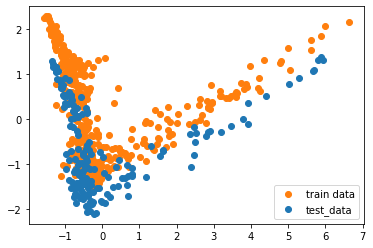

In [36]:
plt.scatter(train_data_transformed[:,0],train_data_transformed[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed[:,0],test_data_transformed[:,1],label="test_data",c=colors_set[0])
plt.legend()
plt.show()

As we can see, the training data and test data are very much in the same space


<AxesSubplot:>

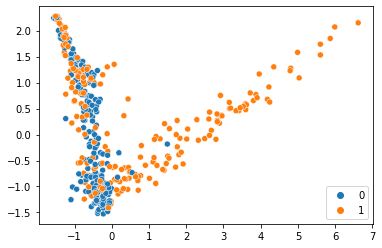

In [37]:
sns.scatterplot(x = train_data_transformed[:,0],y = train_data_transformed[:,1],hue=train_labels)

<AxesSubplot:>

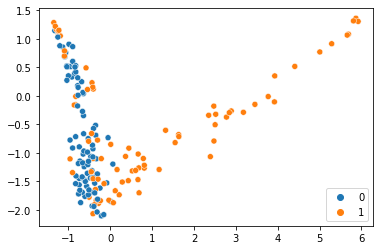

In [38]:
sns.scatterplot(x =test_data_transformed[:,0],y = test_data_transformed[:,1],hue=test_labels)

T-SNE

In [39]:
train_data_transformed_TSNE = TSNE(verbose=1,random_state=0).fit_transform(train_features_norm)
test_data_transformed_TSNE =TSNE(verbose=1,random_state=0).fit_transform(test_features_norm)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.028s...
[t-SNE] Computed neighbors for 450 samples in 1.606s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 1.196201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.966339
[t-SNE] KL divergence after 1000 iterations: 1.203205
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 180 samples in 0.011s...
[t-SNE] Computed neighbors for 180 samples in 0.479s...
[t-SNE] Computed conditional probabilities for sample 180 / 180
[t-SNE] Mean sigma: 1.425544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.252007
[t-SNE] KL divergence after 1000 iterations: 0.960810


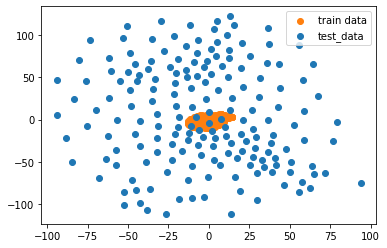

In [40]:
plt.scatter(train_data_transformed_TSNE[:,0],train_data_transformed_TSNE[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_TSNE[:,0],test_data_transformed_TSNE[:,1],label="test_data",c=colors_set[0])
plt.legend()
plt.show()

<AxesSubplot:>

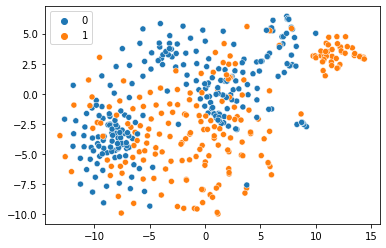

In [41]:
sns.scatterplot(x = train_data_transformed_TSNE[:,0],y = train_data_transformed_TSNE[:,1],hue=train_labels)

<AxesSubplot:>

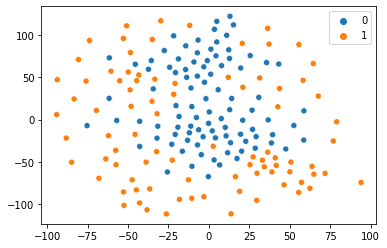

In [42]:
sns.scatterplot(x =test_data_transformed_TSNE[:,0],y = test_data_transformed_TSNE[:,1],hue=test_labels)

UMAP

In [43]:
um = umap.UMAP().fit(train_features_norm)
train_data_transformed_um = um.transform(train_features_norm)
test_data_transformed_um =um.transform(test_features_norm)

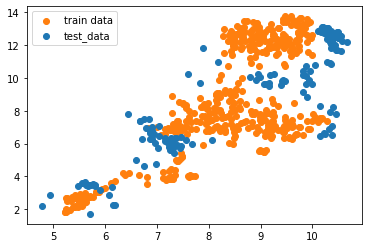

In [44]:
plt.scatter(train_data_transformed_um[:,0],train_data_transformed_um[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_um[:,0],test_data_transformed_um[:,1],label="test_data",c=colors_set[0])
plt.legend()
plt.show()

<AxesSubplot:>

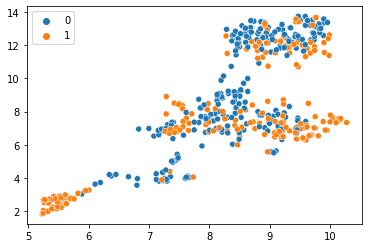

In [45]:
sns.scatterplot(x = train_data_transformed_um[:,0],y = train_data_transformed_um[:,1],hue=train_labels)

<AxesSubplot:>

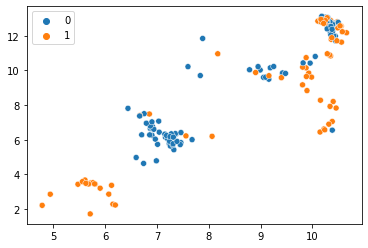

In [46]:
sns.scatterplot(x =test_data_transformed_um[:,0],y = test_data_transformed_um[:,1],hue=test_labels)

MDS

In [47]:
train_data_transformed_MDS = MDS(verbose=1,random_state=0).fit_transform(train_features_norm)
test_data_transformed_MDS =MDS(verbose=1,random_state=0).fit_transform(test_features_norm)


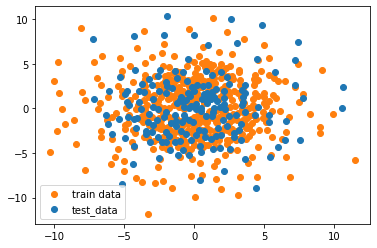

In [48]:
plt.scatter(train_data_transformed_MDS[:,0],train_data_transformed_MDS[:,1],label="train data",c=colors_set[1])
plt.scatter(test_data_transformed_MDS[:,0],test_data_transformed_MDS[:,1],label="test_data",c=colors_set[0])
plt.legend()
plt.show()

<AxesSubplot:>

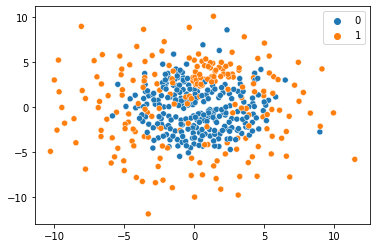

In [49]:
sns.scatterplot(x = train_data_transformed_MDS[:,0],y = train_data_transformed_MDS[:,1],hue=train_labels)

<AxesSubplot:>

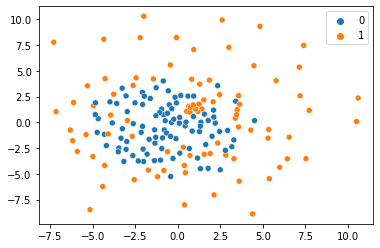

In [50]:
sns.scatterplot(x =test_data_transformed_MDS[:,0],y = test_data_transformed_MDS[:,1],hue=test_labels)